# TraceScene Class Example

The `TraceScene` class is a way to work with multiple PSFs that make up a spectrum trace. You will need to use a PSF to create a trace from, and inside that PSF object there is the information about the trace pixel, wavelength, and sensitivity distributions.

In [1]:
from pandorapsf import TraceScene, PSF
import matplotlib.pyplot as plt
import numpy as np
import pandorasat as ps
import astropy.units as u

In [2]:
p = PSF.from_name("NIRDA").freeze_dimension(row=0, column=0)

In [3]:
p

1D PSF Model [wavelength] (Frozen: row: 0.000, column: 0.000)

This PSF object is a function of wavelength. We can look at the trace sensitivity as a function of pixel and wavelength.

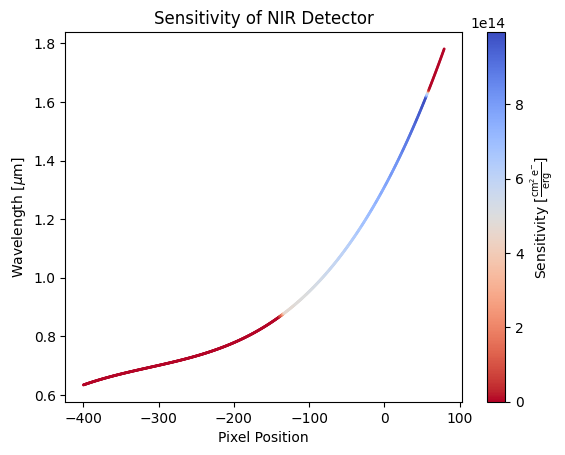

In [4]:
fig, ax = plt.subplots()
im = ax.scatter(p.trace_pixel.value, p.trace_wavelength.value, c=p.trace_sensitivity.value, cmap='coolwarm_r', vmin=0, vmax=p.trace_sensitivity.max().value, s=1)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Sensitivity [{p.trace_sensitivity.unit.to_string('latex')}]")
ax.set(ylabel='Wavelength [$\mu$m]', xlabel='Pixel Position', title='Sensitivity of NIR Detector');

This looks like what we expect. This information is baked into the PSF object. This will be used by the `TraceScene` class. Let's build one

In [5]:
ts = TraceScene(locations=np.asarray([(200, 40)]), psf=p, shape=(400, 80), corner=(0, 0))

In [6]:
ts

TraceScene Object [1D PSF Model [wavelength] (Frozen: row: 0.000, column: 0.000)]

Here I've made a `TraceScene` object where the source is located at (200, 40) in the image. The default wavelength spacing for `TraceScene` is one PSF element per quarter pixel. You can change the grid it is evaluated at using the `wavelenth` keyword argument. Let's see how many wavelength elements there are in the `TraceScene`

In [7]:
ts.nwav

880

In [8]:
ts.wavelength

<Quantity [0.84809537, 0.84852296, 0.84895055, 0.84937989, 0.84980923,
           0.85024032, 0.85067142, 0.85110428, 0.85153714, 0.85197177,
           0.8524064 , 0.8528428 , 0.8532792 , 0.85371738, 0.85415557,
           0.85459553, 0.8550355 , 0.85547725, 0.85591901, 0.85636256,
           0.85680612, 0.85725147, 0.85769682, 0.85814398, 0.85859114,
           0.85904011, 0.85948908, 0.85993987, 0.86039065, 0.86084326,
           0.86129587, 0.86175031, 0.86220475, 0.86266102, 0.86311729,
           0.8635754 , 0.86403351, 0.86449346, 0.86495341, 0.86541521,
           0.86587701, 0.86634067, 0.86680433, 0.86726984, 0.86773536,
           0.86820274, 0.86867012, 0.86913938, 0.86960863, 0.87007976,
           0.87055088, 0.87102389, 0.8714969 , 0.8719718 , 0.8724467 ,
           0.87292349, 0.87340028, 0.87387896, 0.87435765, 0.87483824,
           0.87531883, 0.87580133, 0.87628382, 0.87676824, 0.87725265,
           0.87773898, 0.87822531, 0.87871356, 0.87920182, 0.879692  ,
      

There are many hundreds of elements in this default. This makes the `TraceScene` object slower to calculate than if it had a lower wavelength resolution.

We need a spectrum to create an image. We can do this using `pandorasat`'s SED function, which will return the SED of a target of given effective temperature and magnitude.

In [9]:
target_wavelength, target_spectrum = ps.utils.SED(teff=5777, jmag=13)

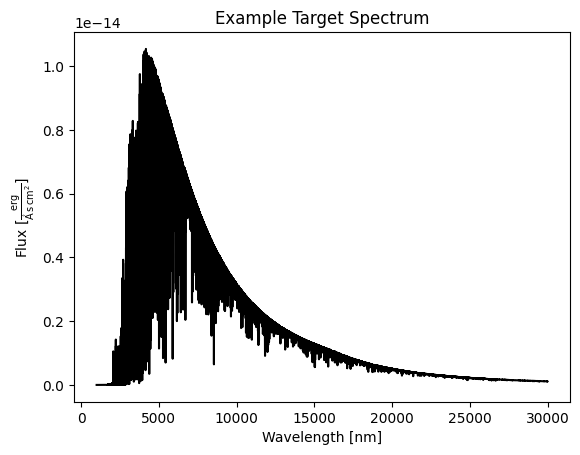

In [10]:
fig, ax = plt.subplots()
ax.plot(target_wavelength, target_spectrum, c='k')
ax.set(xlabel='Wavelength [nm]', ylabel=f"Flux [{target_spectrum.unit.to_string('latex')}]", title='Example Target Spectrum');

This is at a different resolution and wavelength range than the `TraceScene` object. We need to integrate this spectrum onto the wavelength grid of the `TraceScene` object. Let's do that

In [11]:
integrated_spec = ts.integrate_spectrum(*ps.utils.SED(teff=5777, jmag=13))

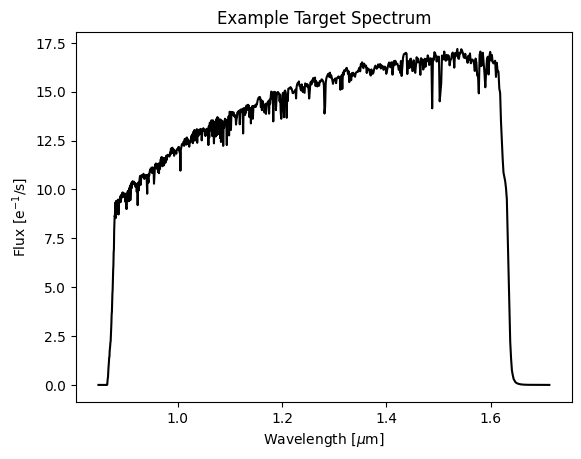

In [12]:
fig, ax = plt.subplots()
ax.plot(ts.wavelength, integrated_spec, c='k')
ax.set(xlabel='Wavelength [$\mu$m]', ylabel='Flux [e$^{-1}$/s]', title='Example Target Spectrum');

This is now the integrated spectrum in each wavelength element of the trace scene, accounting for Pandora's sensitivity and the NIR detector QE. Let's make this into an image on the detector.

In [13]:
images = ts.model(spectra=integrated_spec)

This contains one image for a single time stamp. Let's plot it

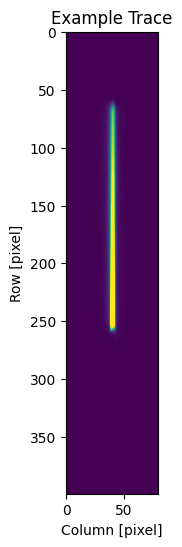

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0].value, vmin=0, vmax=10)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Trace');

This image has units of $e^{-1}/s$. We can then use this image to calculate models of the detector response.

Just like other `Scene` classes this class can be used to create images of traces over time.

In [15]:
nt = 10
images = ts.model(spectra=integrated_spec[:, None, None] * np.arange(nt))

In [16]:
images.shape

(10, 400, 80)

Above I've created spectra that get brighter over 10 time stamps. If we plot the central pixel we see the brightness increasing.

[Text(0.5, 0, 'Frame Number'), Text(0, 0.5, 'Brightness [$e^{-1}$/s]')]

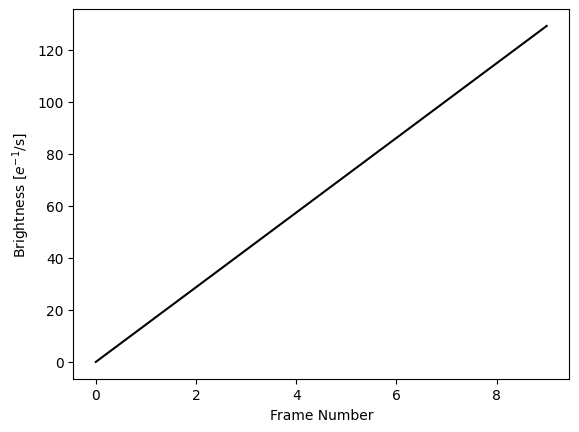

In [17]:
fig, ax = plt.subplots()
ax.plot(images[:, 200, 40], c='k')
ax.set(xlabel='Frame Number', ylabel='Brightness [$e^{-1}$/s]')

You can also create spectra that have motion in them

In [18]:
nt = 10
delta_position = np.random.uniform(-3, 3, (2, nt)).T
images = ts.model(spectra=integrated_spec[:, None, None] * np.ones(nt), delta_pos=delta_position)

Modeling Pixel Positions: 100%|███████████████████| 2/2 [00:01<00:00,  1.91it/s]


In [19]:
images.shape

(10, 400, 80)

Now we have 10 images with the same spectrum, but different positions over time. If we difference image the first and last image we see this change. 

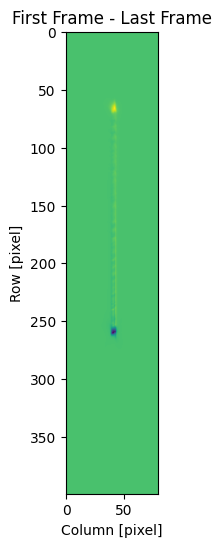

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0].value - images[1].value)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='First Frame - Last Frame');

You can also create a `TraceScene` with multiple targets. Let's create a new scene with two targets.

In [21]:
ts = TraceScene(locations=np.asarray([(200, 40), (170, 35)]), psf=p, shape=(400, 80), corner=(0, 0))

Here I'll create spectra for the two targets

In [22]:
target1 = ts.integrate_spectrum(*ps.utils.SED(teff=5777, jmag=13))
target2 = ts.integrate_spectrum(*ps.utils.SED(teff=3500, jmag=14))

In [23]:
images = ts.model(np.vstack([target1, target2]).T)

In [24]:
images.shape

(1, 400, 80)

This has created one image, because we only passed in one time stamp of spectra

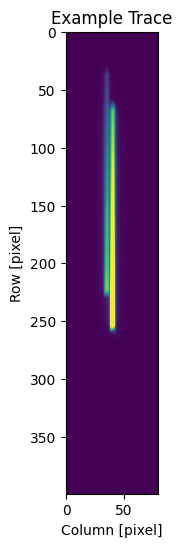

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0].value, vmin=0, vmax=10)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Trace');

Now we have two spectra in our image, one for each target. We can similarly change the spectra for each timestamp, or add in motion to the scene. 

In [26]:
nt = 10
delta_position = np.random.uniform(-3, 3, (2, nt)).T
images = ts.model(spectra=np.vstack([target1, target2]).T[:, :, None] * np.ones(nt), delta_pos=delta_position)

Modeling Pixel Positions: 100%|███████████████████| 2/2 [00:02<00:00,  1.00s/it]


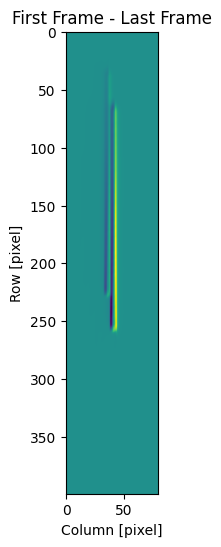

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0].value - images[1].value)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='First Frame - Last Frame');